In [4]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from astropy.io import ascii
from tqdm import tqdm
from astropy.convolution import convolve, Gaussian1DKernel
import pandas as pd
import matplotlib as mpl
import matplotlib.ticker as mticker
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.linear_model import LinearRegression
from scipy import stats
import pickle
from doublet_quantifier.curvefit import *
from doublet_quantifier.models import *

In [5]:
mypath = '/Users/allybaldelli/Desktop/AMNH-stuff/quantifying_clouds_ally/' # path to this directory 
sys.path.append(mypath)

from functions.plotting_tools import *
from functions.data_tools import *

In [6]:
# opening pseudo-voigt parameter DataFrame
with open(mypath + "diamondback-data/pickle_files/parameters/t1600_parameter_df.pkl", "rb") as f:
    parameter_df = pickle.load(f)

### preforming cross validation 

In [7]:
# taking out the nc as fsed is not reliable
cv_data = parameter_df[parameter_df.clouds != 10]

# defining the cross-validation data for easy access
cv_A = -((cv_data.A1 + cv_data.A2)/2).values
cv_fsed = cv_data.clouds.values
cv_FWHM = ((cv_data.FWHM1 + cv_data.FWHM2)/2).values
cv_logg = cv_data.logg.values

# Create a linear regression model
model = LinearRegression()

# Performing loo cross-validation for logg
loo = LeaveOneOut()
squared_errors = []

for train_index, test_index in loo.split(cv_FWHM):
    X_train, X_test = cv_FWHM[train_index].reshape(
        -1, 1), cv_FWHM[test_index].reshape(-1, 1)
    y_train, y_test = cv_logg[train_index].reshape(
        -1, 1), cv_logg[test_index].reshape(-1, 1)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    squared_errors.append((y_pred - y_test) ** 2)

RMSE_logg = np.sqrt(np.mean(squared_errors))
Pearson_corr_coef_1, p_value = stats.pearsonr(cv_logg, cv_FWHM)

# Print the cross-validation scores
print(f'Root Mean Square Error for logg: {RMSE_logg}')
print("Pearson product-moment correlation coefficient:", Pearson_corr_coef_1)
print("P-value:", p_value)
print()

# Performing loo cross-validation for fsed
squared_errors = []

for train_index, test_index in loo.split(cv_A):
    X_train, X_test = cv_A[train_index].reshape(
        -1, 1), cv_A[test_index].reshape(-1, 1)
    y_train, y_test = cv_fsed[train_index].reshape(
        -1, 1), cv_fsed[test_index].reshape(-1, 1)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    squared_errors.append((y_pred - y_test) ** 2)

RMSE_fsed = np.sqrt(np.mean(squared_errors))
scores = cross_val_score(model, cv_A.reshape(-1, 1),
                         cv_fsed.reshape(-1, 1), cv=5, scoring='neg_mean_squared_error')
Pearson_corr_coef_2, p_value = stats.pearsonr(cv_fsed, cv_A)
# Print the cross-validation scores
print(f'Root Mean Square Error for fsed: {RMSE_fsed}')
print("Pearson product-moment correlation coefficient:", Pearson_corr_coef_2)
print("P-value:", p_value)

Root Mean Square Error for logg: 0.08658190188808801
Pearson product-moment correlation coefficient: 0.993534906566649
P-value: 3.0635983990314497e-23

Root Mean Square Error for fsed: 1.3910251040267538
Pearson product-moment correlation coefficient: 0.8416360232835425
P-value: 1.3496586421979425e-07


In [8]:
stats.pearsonr(cv_fsed, cv_FWHM)

PearsonRResult(statistic=0.048725627949074195, pvalue=0.8170877018035654)

In [9]:
fsed_values = np.array([i for i in range(0, 10)])
logg_values = np.array([i for i in range(3, 7)])

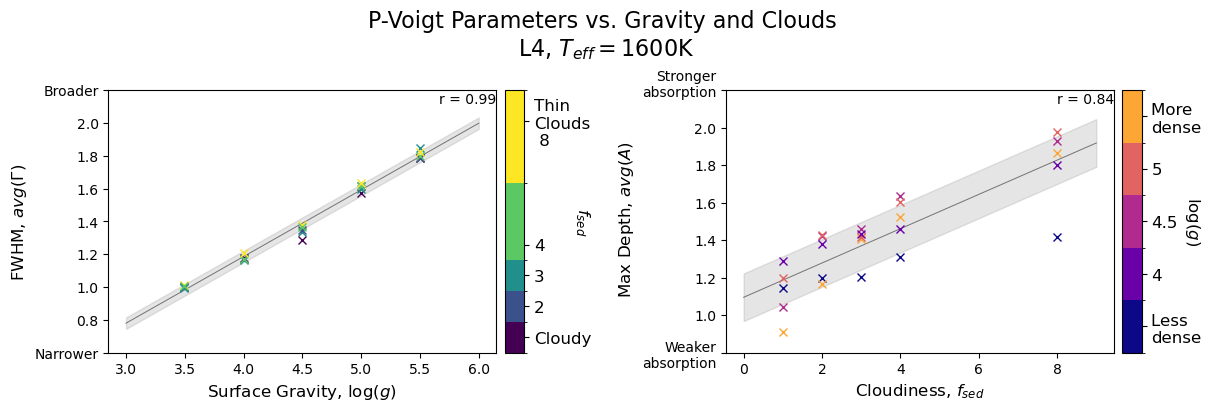

In [10]:
fig = plt.figure(figsize=(12, 4), constrained_layout=True)

gs = fig.add_gridspec(1, 4, width_ratios=[1, 0.05, 1, 0.05])

ax1, ax2 = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 2])
cax1, cax2 = fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 3])

# plotting data points
for i in range(len(cv_FWHM)):
    ax1.errorbar(cv_logg[i], cv_FWHM[i],
                 color=fsed_colors(norm_f(cv_fsed[i])), fmt='x')
    ax2.errorbar(cv_fsed[i], cv_A[i],
                 color=logg_colors(norm_g(cv_logg[i])), fmt='x')

# plotting lines
m, b = np.polyfit(cv_logg, cv_FWHM, 1)
y_est = logg_values*m + b
ax1.plot(logg_values, y_est, color='k',
         linewidth=.7, alpha=0.5, label=f'{m:.2}x + {b:.2}')
upper_bound = (logg_values + RMSE_logg)*m + b
lower_bound = (logg_values - RMSE_logg)*m + b
ax1.fill_between(logg_values, lower_bound,
                 upper_bound, alpha=0.2, color='grey')


m, b = np.polyfit(cv_fsed, cv_A, 1)
y_est = fsed_values*m + b
ax2.plot(fsed_values, y_est, color='k',
         linewidth=.7, alpha=0.5, label=f'{m:.2}x + {b:.2}')
upper_bound = (fsed_values - RMSE_fsed)*m + b
lower_bound = (fsed_values + RMSE_fsed)*m + b
ax2.fill_between(fsed_values, lower_bound,
                 upper_bound, alpha=0.2, color='grey')

# Colorbar

axcb = logg_colorbar(fig, cax=cax2,  orientation='vertical', pad=0.1)
axcb.set_label(r'$\log(g)$', fontsize=12, rotation=-90, labelpad=0)


axcb = fsed_colorbar(fig, cax=cax1,  orientation='vertical', pad=0.1)
axcb.set_label(r'$f_{sed}$', fontsize=12, rotation=-90, labelpad=0)


# r value
ax1.annotate(f"r = {Pearson_corr_coef_1:.2}", xy=(1, 0.99),
             ha='right', va='top',
             fontsize=10,
             xycoords='axes fraction', color='k')
ax2.annotate(f"r = {Pearson_corr_coef_2:.2}", xy=(1, 0.99),
             ha='right', va='top',
             fontsize=10,
             xycoords='axes fraction', color='k')

# set axis
yticks = ax2.get_yticks()
ylabel = list(yticks.copy()/1e11)
ylabel[-1] = "Stronger\nabsorption\n"
ylabel[0] = "Weaker\nabsorption"
ax2.set_yticks(yticks)
ax2.set_yticklabels(ylabel)

yticks = ax1.get_yticks()
ylabel = list(np.around(yticks.copy()/1e-3, 1))
ylabel[-1] = "Broader"
ylabel[0] = "Narrower"
ax1.set_yticks(yticks)
ax1.set_yticklabels(ylabel)
ax1.set_yticks(yticks)


# set labels
ax2.set_ylabel("\n Max Depth, $avg(A)$", fontsize=12)
ax1.set_ylabel("FWHM, $avg(Γ)$", fontsize=12)
ax1.set_xlabel("Surface Gravity, " + r'$\log(g)$', fontsize=12)
ax2.set_xlabel("Cloudiness, " + r"$f_{sed}$", fontsize=12)

fig.suptitle("P-Voigt Parameters vs. Gravity and Clouds \n" +
             r"L4, $T_{eff} = 1600 \text{K}$", fontsize=16)

plt.savefig(
    "/Users/allybaldelli/Desktop/AMNH-stuff/quantifying_clouds_ally/plots/CV_plot.png")

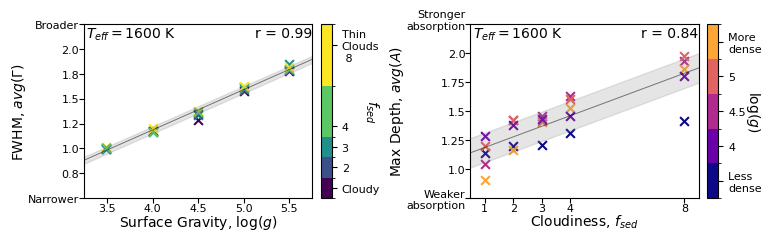

In [38]:
ticks_font_size = 8
labels_font_size = 10

fig = plt.figure(figsize=(3.8 * 2, 2.3), constrained_layout=True)

gs = fig.add_gridspec(1, 4, width_ratios=[1, 0.05, 1, 0.05])

ax1, ax2 = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 2])
cax1, cax2 = fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 3])




# plotting data points
for i in range(len(cv_FWHM)):
    ax1.scatter(cv_logg[i], cv_FWHM[i],
                color=fsed_colors(norm_f(cv_fsed[i])), marker='x', s=40)
    ax2.scatter(cv_fsed[i], cv_A[i],
                color=logg_colors(norm_g(cv_logg[i])), marker='x', s=40)

# plotting lines
m, b = np.polyfit(cv_logg, cv_FWHM, 1)
y_est = logg_values*m + b
ax1.plot(logg_values, y_est, color='k',
         linewidth=.7, alpha=0.5, label=f'{m:.2}x + {b:.2}')
upper_bound = (logg_values + RMSE_logg)*m + b
lower_bound = (logg_values - RMSE_logg)*m + b
ax1.fill_between(logg_values, lower_bound,
                 upper_bound, alpha=0.2, color='grey')


m, b = np.polyfit(cv_fsed, cv_A, 1)
y_est = fsed_values*m + b
ax2.plot(fsed_values, y_est, color='k',
         linewidth=.7, alpha=0.5, label=f'{m:.2}x + {b:.2}')
upper_bound = (fsed_values - RMSE_fsed)*m + b
lower_bound = (fsed_values + RMSE_fsed)*m + b
ax2.fill_between(fsed_values, lower_bound,
                 upper_bound, alpha=0.2, color='grey')

# Colorbar

axcb = logg_colorbar(fig, cax=cax2,  orientation='vertical', pad=0, fontsize=ticks_font_size)
axcb.set_label(r'$\log(g)$', fontsize=labels_font_size,
               rotation=-90, labelpad=0, position="right")


axcb = fsed_colorbar(fig, cax=cax1,  orientation='vertical', pad=0, fontsize=ticks_font_size)
axcb.set_label(r"$f_{sed}$", fontsize=labels_font_size, rotation=-90, labelpad=0)


# annotating r value
ax1.annotate(f"r = {Pearson_corr_coef_1:.2}", xy=(1, 0.99),
             ha='right', va='top',
             fontsize=labels_font_size,
             xycoords='axes fraction', color='k')
ax2.annotate(f"r = {Pearson_corr_coef_2:.2}", xy=(1, 0.99),
             ha='right', va='top',
             fontsize=labels_font_size,
             xycoords='axes fraction', color='k')

# annotating Teff
ax1.annotate(r"$T_{eff} = 1600 \text{ K}$", xy=(0.01, 0.99),
             ha='left', va='top',
             fontsize=labels_font_size,
             xycoords='axes fraction', color='k')
ax2.annotate(r"$T_{eff} = 1600 \text{ K}$", xy=(0.01, 0.99),
             ha='left', va='top',
             fontsize=labels_font_size,
             xycoords='axes fraction', color='k')

# set axis ticks 
yticks = ax2.get_yticks()
ylabel = list(yticks.copy()/1e11)
ylabel[-1] = "Stronger\nabsorption\n"
ylabel[0] = "Weaker\nabsorption"
ax2.set_yticks(yticks)
ax2.set_yticklabels(ylabel)

yticks = ax1.get_yticks()
ylabel = list(np.around(yticks.copy()/1e-3, 1))
ylabel[-1] = "Broader"
ylabel[0] = "Narrower"
ax1.set_yticks(yticks)
ax1.set_yticklabels(ylabel)

ax1.set_xticks(logg_num)
ax2.set_xticks(fsed_num)

ax1.tick_params(axis='both', which='major', pad=0, labelsize = ticks_font_size)
ax2.tick_params(axis='both', which='major', pad=0, labelsize = ticks_font_size)

# set axis limits
ax1.set_xlim(3.25, 5.75)
ax2.set_xlim(0.5, 8.5)

# set labels
ax2.set_ylabel("Max Depth, $avg(A)$", fontsize=10, labelpad=0)
ax1.set_ylabel("FWHM, $avg(Γ)$", fontsize= labels_font_size, labelpad=0)
ax1.set_xlabel("Surface Gravity, " + r'$\log(g)$', fontsize=10, labelpad=0)
ax2.set_xlabel("Cloudiness, " + r"$f_{sed}$", fontsize= labels_font_size, labelpad=0)

# set title 
# ax1.set_title(r"$T_{eff} = 1600 \text{K}$", fontsize=12)
# ax2.set_title(r"$T_{eff} = 1600 \text{K}$", fontsize=12)

# save figures 
fig.savefig('/Users/allybaldelli/Desktop/AMNH-stuff/quantifying_clouds_ally/plots/CV_wide.pdf',
             bbox_inches='tight', pad_inches=0.01)


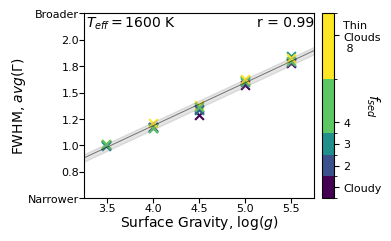

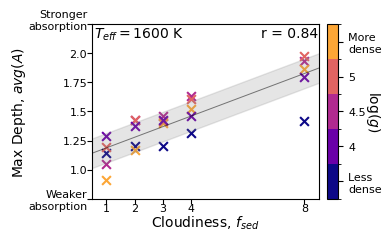

In [36]:
ticks_font_size = 8
labels_font_size = 10

fig1 = plt.figure(figsize=(3.8, 2.3), constrained_layout=True)
fig2 = plt.figure(figsize=(3.8, 2.3), constrained_layout=True)

gs = fig1.add_gridspec(1, 2, width_ratios=[1, 0.05])
ax1 = fig1.add_subplot(gs[0, 0])
cax1 = fig1.add_subplot(gs[0, 1])

gs = fig2.add_gridspec(1, 2, width_ratios=[1, 0.05])
ax2 = fig2.add_subplot(gs[0, 0])
cax2 = fig2.add_subplot(gs[0, 1])

# plotting data points
for i in range(len(cv_FWHM)):
    ax1.scatter(cv_logg[i], cv_FWHM[i],
                color=fsed_colors(norm_f(cv_fsed[i])), marker='x', s=40)
    ax2.scatter(cv_fsed[i], cv_A[i],
                color=logg_colors(norm_g(cv_logg[i])), marker='x', s=40)

# plotting lines
m, b = np.polyfit(cv_logg, cv_FWHM, 1)
y_est = logg_values*m + b
ax1.plot(logg_values, y_est, color='k',
         linewidth=.7, alpha=0.5, label=f'{m:.2}x + {b:.2}')
upper_bound = (logg_values + RMSE_logg)*m + b
lower_bound = (logg_values - RMSE_logg)*m + b
ax1.fill_between(logg_values, lower_bound,
                 upper_bound, alpha=0.2, color='grey')


m, b = np.polyfit(cv_fsed, cv_A, 1)
y_est = fsed_values*m + b
ax2.plot(fsed_values, y_est, color='k',
         linewidth=.7, alpha=0.5, label=f'{m:.2}x + {b:.2}')
upper_bound = (fsed_values - RMSE_fsed)*m + b
lower_bound = (fsed_values + RMSE_fsed)*m + b
ax2.fill_between(fsed_values, lower_bound,
                 upper_bound, alpha=0.2, color='grey')

# Colorbar

axcb = logg_colorbar(fig, cax=cax2,  orientation='vertical', pad=0, fontsize=ticks_font_size)
axcb.set_label(r'$\log(g)$', fontsize=labels_font_size,
               rotation=-90, labelpad=0, position="right")


axcb = fsed_colorbar(fig, cax=cax1,  orientation='vertical', pad=0, fontsize=ticks_font_size)
axcb.set_label(r"$f_{sed}$", fontsize=labels_font_size, rotation=-90, labelpad=0)


# annotating r value
ax1.annotate(f"r = {Pearson_corr_coef_1:.2}", xy=(1, 0.99),
             ha='right', va='top',
             fontsize=labels_font_size,
             xycoords='axes fraction', color='k')
ax2.annotate(f"r = {Pearson_corr_coef_2:.2}", xy=(1, 0.99),
             ha='right', va='top',
             fontsize=labels_font_size,
             xycoords='axes fraction', color='k')

# annotating Teff
ax1.annotate(r"$T_{eff} = 1600 \text{ K}$", xy=(0.01, 0.99),
             ha='left', va='top',
             fontsize=labels_font_size,
             xycoords='axes fraction', color='k')
ax2.annotate(r"$T_{eff} = 1600 \text{ K}$", xy=(0.01, 0.99),
             ha='left', va='top',
             fontsize=labels_font_size,
             xycoords='axes fraction', color='k')

# set axis ticks 
yticks = ax2.get_yticks()
ylabel = list(yticks.copy()/1e11)
ylabel[-1] = "Stronger\nabsorption\n"
ylabel[0] = "Weaker\nabsorption"
ax2.set_yticks(yticks)
ax2.set_yticklabels(ylabel)

yticks = ax1.get_yticks()
ylabel = list(np.around(yticks.copy()/1e-3, 1))
ylabel[-1] = "Broader"
ylabel[0] = "Narrower"
ax1.set_yticks(yticks)
ax1.set_yticklabels(ylabel)

ax1.set_xticks(logg_num)
ax2.set_xticks(fsed_num)

ax1.tick_params(axis='both', which='major', pad=0, labelsize = ticks_font_size)
ax2.tick_params(axis='both', which='major', pad=0, labelsize = ticks_font_size)

# set axis limits
ax1.set_xlim(3.25, 5.75)
ax2.set_xlim(0.5, 8.5)

# set labels
ax2.set_ylabel("Max Depth, $avg(A)$", fontsize=10, labelpad=0)
ax1.set_ylabel("FWHM, $avg(Γ)$", fontsize= labels_font_size, labelpad=0)
ax1.set_xlabel("Surface Gravity, " + r'$\log(g)$', fontsize=10, labelpad=0)
ax2.set_xlabel("Cloudiness, " + r"$f_{sed}$", fontsize= labels_font_size, labelpad=0)

# set title 
# ax1.set_title(r"$T_{eff} = 1600 \text{K}$", fontsize=12)
# ax2.set_title(r"$T_{eff} = 1600 \text{K}$", fontsize=12)

# save figures 
fig1.savefig('/Users/allybaldelli/Desktop/AMNH-stuff/quantifying_clouds_ally/plots/FWHMvsLogg.pdf',
             bbox_inches='tight', pad_inches=0.01)
fig2.savefig('/Users/allybaldelli/Desktop/AMNH-stuff/quantifying_clouds_ally/plots/AvsFsed.pdf',
             bbox_inches='tight', pad_inches=0.01)